# Wedding Attendance Estimator

## Overview
This Jupyter Notebook uses a Monte Carlo Simulation to estimate the distribution of attendance to a wedding using Python, NumPy, Matplotlib, and pandas.  The analysis returns potential ranges of people to expect at your wedding with associated levels of confidence.  Using accurate attendance estimates and ranges are key to planning successful events.

## Input
Input is provided by the user in the form of a CSV file with the headers ("Chance_of_Attendance,Party_Size") on the first line.  Each subsequent line then contains two values separated by a comma describing that *guest party*.  A guest party should be considered a close and collected group of guests such as a single person, a couple, or a family.  The first value is the chance of that guest party attending the wedding.  The second number is the total number of people in that guest party (single, couple, family).

### Input Modifications
A Notebook variable `include_plus_ones` can be set to True or False.  A True setting adds a plus-one invite to any *guest party* that had an original total size of 1 person in the CSV file.  The plus-one invite may go used or unused.  A random draw with a stated probability distribution is used to decide if each plus-one is used in each simulation or not.  The uniform probability of a plus-one attending is common to all guest parties and can be set using the variable `chance_of_plus_ones`.  A False setting of `include_plus_ones` leaves each guest party at the size defined in the CSV input file.

## Output
The results of the analysis are provided in textual, tabular, and graphical representations to help the user better understand the likely event attendance.

## Architecture
Input is provided to the Jupyter Notebook through a user-supplied CSV file containing a list of guest parties invited to a wedding, including their guest count and the probability of each party attending the event. The CSV is consumed into a pandas dataframe and then Monte Carlo simulations are run for the selected number of simulations, `num_simulations`. Each simulation uses NumPy's random method and the user-supplied guest party's probability to determine if each guest party attends the event or not. A resulting histogram of total wedding attendance is then displayed showing the distribution of attendees to be expected at the wedding.

## Assumptions
1. Either the whole *guest party* attends, or none of the CSV listed guest party attends.  (Exception for plus-one invites.)
1. Each *guest party's* decision to attend the wedding or not is independent of the decision of another *guest party's* decision to attend or not.  For example, the simulation does not take into account dependent situations such as  "I'm only going if my brother also attends." or "I'm only going if my ex isn't attending."
1. The user did a fantastic job predicting the chances of each *guest party* attending in the CSV file.  The user should try to reflect influencing circumstances such as local/out-of-town guest, financial ability, calendar availability, and strength of relationship when estimating the chance of a guest party attending.
1. When using the plus-one invite function, all plus-one invites have the same probability of attending.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from tabulate import tabulate

# Importing and reading CSV file provided by user
df = pd.read_csv('wedding_guests.csv')

# can adjust number of simulations to increase accuracy at expense of runtime
num_simulations = 10000
sim_results = []

for i in range(num_simulations):
  # randomly determine if each party will be attending this instance of the wedding using weighted probabilities provided in the user CSV input
  df['Attending?'] = df.apply(lambda row: np.random.choice([1,0],p=[row.Chance_of_Attendance, 1-row.Chance_of_Attendance]),axis=1)

  df['Attending_Size'] = df['Party_Size'] * df['Attending?']

  sim_results.append([
  df['Attending?'].sum(),
  df['Attending_Size'].mean(),
  df['Attending_Size'].sum().round(0)])

# aggregate all of the sim information and print a summary
results_df = pd.DataFrame.from_records(sim_results, columns=['Parties Attending','Average Party Size','Total Attendees'])

results_df.describe().style.format(precision=2)

,Parties Attending,Average Party Size,Total Attendees
count,10000.00,10000.00,10000.00
mean,59.83,1.21,102.88
std,3.33,0.07,6.05
min,46.00,0.92,78.00
25%,58.00,1.16,99.00
50%,60.00,1.21,103.00
75%,62.00,1.26,107.00
max,72.00,1.47,125.00


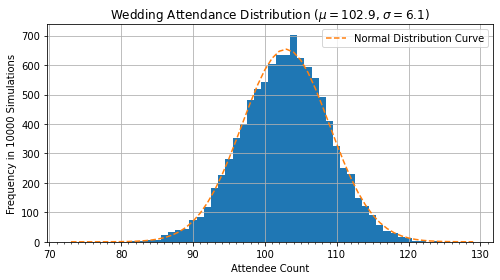

In [2]:
## create a histogram plot to visually communicate the results of the analysis

# ensure each bin is 1 person wide
bin_sizing = range(results_df['Total Attendees'].min()-5,results_df['Total Attendees'].max()+5,1)

# create initial histogram
ax = results_df['Total Attendees'].plot(kind='hist', bins=bin_sizing, align='left', figsize=(8,4))

# pre-calculate values for title and labels
sim_mean = results_df['Total Attendees'].mean().round(1)
sim_std = results_df['Total Attendees'].std().round(1)

# format and add info to the plot
ax.set_title(f'Wedding Attendance Distribution ($\mu=${sim_mean}, $\sigma=${sim_std})')
ax.set_xlabel('Attendee Count')
ax.set_ylabel(f'Frequency in {num_simulations} Simulations')
ax.xaxis.set_minor_locator(plt.ticker.MultipleLocator(1))
ax.grid(which='major', axis='both')

# calculate the normal distribution curve to show it fits
y = ((1 / (np.sqrt(2 * np.pi) * sim_std)) * np.exp(-0.5 * (1 / sim_std * (bin_sizing - sim_mean))**2))
ax.plot(bin_sizing, y*num_simulations, '--')
ax.legend(['Normal Distribution Curve'])


In [3]:
## provide a verbal explanation of the data with key takeaways

total_invited = df['Party_Size'].sum()
sim_max = results_df['Total Attendees'].max()

print(f"Typically, wedding websites will tell you to expect 80% of your invitees to attend.  You have invited {total_invited} people to the wedding.  The 80% rule would tell you to expect {round(0.8*total_invited)} people.  The highest attendance count seen in {num_simulations} simulations was {sim_max} people.\n")

print(f"The Monte Carlo Analysis using {num_simulations} simulations matches the form of a normal distribution with a mean of {sim_mean} people and a standard deviation of {sim_std} people.  Using this normalized distribution characterization, the table below provides estimates of attendance ranges along with their likelihood.\n")

headers = ['Confidence','Range Minimum', 'Range Maximum', '\u03C3']
table_data = [
  ['84.13%',0,0,'1\u03C3'],
  ['93.32%',0,0,'1.5\u03C3'],
  ['97.73%',0,0,'2\u03C3'],
  ['99.38%',0,0,'2.5\u03C3'],
  ['99.87%',0,0,'3\u03C3'],
  ['99.98%',0,0,'3.5\u03C3'],
]
sigma = 1

for row in range(len(table_data)):
  table_data[row][1] = sim_mean - sigma * sim_std
  table_data[row][2] = sim_mean + sigma * sim_std
  sigma += 0.5

print("*"*13 + "ATTENDANCE RANGES WITH CONFIDENCE" + "*"*13 + "\n")
print(tabulate(table_data,headers=headers, tablefmt='orgtbl', numalign='center', stralign='center'))

Typically, wedding websites will tell you to expect 80% of your invitees to attend.  You have invited 148 people to the wedding.  The 80% rule would tell you to expect 118 people.  The highest attendance count seen in 10000 simulations was 125 people.

The Monte Carlo Analysis using 10000 simulations matches the form of a normal distribution with a mean of 102.9 people and a standard deviation of 6.1 people.  Using this normalized distribution characterization, the table below provides estimates of attendance ranges along with their likelihood.

*************ATTENDANCE RANGES WITH CONFIDENCE*************

|  Confidence  |  Range Minimum  |  Range Maximum  |  σ   |
|--------------+-----------------+-----------------+------|
|    84.13%    |      96.8       |       109       |  1σ  |
|    93.32%    |      93.75      |     112.05      | 1.5σ |
|    97.73%    |      90.7       |      115.1      |  2σ  |
|    99.38%    |      87.65      |     118.15      | 2.5σ |
|    99.87%    |      84.6 